<a href="https://colab.research.google.com/github/lovnishverma/AI-Mask-Compliance-Monitor/blob/main/Live_Face_Mask_Detection_Ai_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time Face Mask Detection with YOLOv8 + TensorFlow.js (Two-Step Pipeline)

**Features:**
- Train YOLOv8 on face mask dataset
- Export to TensorFlow.js
- **Detect faces** using **BlazeFace**
- **Classify mask/no-mask** per face
- Real-time webcam inference in browser
- No server needed!

---


## 1. Install & Import

In [1]:
!pip install ultralytics kagglehub -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.3 MB/s eta 0:00:00


In [2]:
import kagglehub
import os, shutil, glob, random, json
from pathlib import Path
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Download Dataset

In [3]:
# Download face mask dataset
dataset_path = kagglehub.dataset_download('omkargurav/face-mask-dataset')
input_dir = f"{dataset_path}/data"
print(f"Dataset downloaded to: {input_dir}")

Using Colab cache for faster access to the 'face-mask-dataset' dataset.
Dataset downloaded to: /kaggle/input/face-mask-dataset/data


## 3. Prepare Dataset

In [4]:
def prepare_dataset(input_dir, output_dir='/content/face_mask_split', train_split=0.8):
    os.makedirs(output_dir, exist_ok=True)
    class_names = ['with_mask', 'without_mask']

    for split in ['train', 'val']:
        for cls in class_names:
            os.makedirs(f"{output_dir}/{split}/{cls}", exist_ok=True)

    for cls in class_names:
        src = f"{input_dir}/{cls}"
        imgs = glob.glob(f"{src}/*.jpg") + glob.glob(f"{src}/*.png")
        random.shuffle(imgs)
        n_train = int(len(imgs) * train_split)
        for i, img in enumerate(imgs):
            dst = f"{output_dir}/{'train' if i < n_train else 'val'}/{cls}/{os.path.basename(img)}"
            shutil.copy2(img, dst)
    print("Dataset prepared!")

prepare_dataset(input_dir)

Dataset prepared!


## 4. Train YOLOv8 Classifier

In [5]:
model = YOLO('yolov8n-cls.pt')
results = model.train(
    data='/content/face_mask_split',
    epochs=25,
    imgsz=224,
    batch=16,
    device=0,
    patience=10,
    augment=True
)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/face_mask_split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, 

## 5. Evaluate

In [6]:
metrics = model.val()
print(f"Top-1 Accuracy: {metrics.top1*100:.2f}%")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/face_mask_split/train... found 6042 images in 2 classes ✅ 
val: /content/face_mask_split/val... found 1511 images in 2 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1418.0±1035.4 MB/s, size: 59.8 KB)
val: Scanning /content/face_mask_split/val... 1511 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1511/1511 3.6Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 95/95 17.1it/s 5.5s
                   all      0.999          1
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val
Top-1 Accuracy: 99.93%


## 6. Export to TensorFlow.js

In [7]:
best_pt = 'runs/classify/train/weights/best.pt'
!yolo export model=$best_pt format=tfjs

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 2) (2.8 MB)
E0000 00:00:1761674437.655351    5406 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761674437.661288    5406 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761674437.676402    5406 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:176167443

## 7. Download Model for Web

In [8]:
!zip -r model_web.zip runs/classify/train/weights/best_web_model
from google.colab import files
files.download('model_web.zip')

  adding: runs/classify/train/weights/best_web_model/ (stored 0%)
  adding: runs/classify/train/weights/best_web_model/group1-shard1of2.bin (deflated 7%)
  adding: runs/classify/train/weights/best_web_model/model.json (deflated 94%)
  adding: runs/classify/train/weights/best_web_model/metadata.yaml (deflated 36%)
  adding: runs/classify/train/weights/best_web_model/group1-shard2of2.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8. Full Web App (Face Detection + Mask Classification)


**Two-step real-time pipeline in browser:**

1. **BlazeFace** → Detects all faces  
2. **Your trained YOLOv8 model** → Classifies **with_mask / without_mask** per face

**No backend. No Flask. 100% client-side.**

---

### Final Folder Structure (Local)

```
mask-detection-web/
├── index.html
└── model_web/
    ├── model.json
    ├── group1-shard1of3.bin
    ├── ...
```

---

### Step-by-Step Instructions

1. **Download** `model_web.zip` from the previous cell
2. **Unzip** → creates folder `model_web/`
3. **Create** `index.html` in the same folder
4. **Paste** the full HTML code below
5. **Run a local server** (required for webcam)

---

### Full `index.html` (Copy & Save)


### Complete `index.html`

Copy and paste this entire code into your `index.html` file. It's all you need.

```html
<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>AI Mask Compliance Monitor</title>
    <script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@4.15.0"></script>
    <script src="https://cdn.jsdelivr.net/npm/@tensorflow-models/blazeface"></script>

    <style>
        :root {
            --col-green: #00ff84;
            --col-red: #ff4b4b;
            --col-bg: #0e0e0e;
            --col-surface: rgba(30, 30, 30, 0.9);
            --col-text: #ffffff;
        }

        body {
            margin: 0;
            background-color: var(--col-bg);
            color: var(--col-text);
            font-family: "Segoe UI", Roboto, Helvetica, Arial, sans-serif;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: flex-start;
            height: 100vh;
            padding-top: 1.5rem;
        }

        h2 {
            font-weight: 700;
            font-size: 2.2rem;
            margin-bottom: 1rem;
            letter-spacing: 1px;
        }

        #alert-banner {
            display: none;
            width: 100%;
            text-align: center;
            background-color: var(--col-red);
            color: white;
            font-weight: 700;
            font-size: 1.1rem;
            padding: 10px 0;
            animation: flash 1s infinite alternate;
        }

        @keyframes flash {
            from {
                opacity: 1;
            }

            to {
                opacity: 0.4;
            }
        }

        #stats-container {
            display: flex;
            gap: 1.5rem;
            margin-bottom: 1rem;
            flex-wrap: wrap;
            justify-content: center;
        }

        .stat-card {
            background-color: var(--col-surface);
            padding: 1rem 1.5rem;
            border-radius: 12px;
            text-align: center;
            min-width: 150px;
            backdrop-filter: blur(8px);
            transition: 0.3s;
        }

        .stat-card h3 {
            margin: 0 0 0.5rem 0;
            font-size: 0.9rem;
            text-transform: uppercase;
            letter-spacing: 1px;
        }

        .stat-card-number {
            font-size: 2rem;
            font-weight: 700;
        }

        #mask-count {
            color: var(--col-green);
        }

        #nomask-count {
            color: var(--col-red);
        }

        #container {
            position: relative;
            display: inline-block;
            border-radius: 12px;
            overflow: hidden;
            box-shadow: 0 8px 30px rgba(0, 0, 0, 0.6);
        }

        #video,
        #canvas {
            width: 640px;
            height: 480px;
            border-radius: 12px;
        }

        canvas {
            position: absolute;
            top: 0;
            left: 0;
        }

        .label {
            position: absolute;
            padding: 5px 8px;
            border-radius: 6px;
            font-weight: bold;
            font-size: 14px;
            color: #fff;
            text-shadow: 0 0 5px rgba(0, 0, 0, 0.7);
        }

        #performance {
            margin-top: 1rem;
            font-size: 0.9rem;
            opacity: 0.7;
        }
    </style>
</head>

<body>
    <h2>AI Mask Compliance Monitor</h2>
    <div id="alert-banner">⚠️ MASK VIOLATION DETECTED!</div>

    <div id="stats-container">
        <div class="stat-card">
            <h3>With Mask</h3>
            <div id="mask-count" class="stat-card-number">0</div>
        </div>
        <div class="stat-card" id="nomask-card">
            <h3>No Mask</h3>
            <div id="nomask-count" class="stat-card-number">0</div>
        </div>
        <div class="stat-card">
            <h3>Total Detections</h3>
            <div id="total-count" class="stat-card-number">0</div>
        </div>
        <div class="stat-card">
            <h3>FPS</h3>
            <div id="fps" class="stat-card-number">0</div>
        </div>
    </div>

    <div id="container">
        <video id="video" autoplay playsinline></video>
        <canvas id="canvas" width="640" height="480"></canvas>
    </div>

    <div id="performance">Session running...</div>

    <script>
        const video = document.getElementById('video');
        const canvas = document.getElementById('canvas');
        const ctx = canvas.getContext('2d');
        const maskEl = document.getElementById('mask-count');
        const noMaskEl = document.getElementById('nomask-count');
        const totalEl = document.getElementById('total-count');
        const fpsEl = document.getElementById('fps');
        const alertBanner = document.getElementById('alert-banner');

        let faceModel, maskModel;
        let audioContext;
        let lastAlertTime = 0;
        const alertThrottle = 2000;
        let lastFrameTime = performance.now();

        let totalMasks = 0, totalNoMasks = 0, totalDetections = 0;

        function playAlert() {
            if (!audioContext) return;
            const oscillator = audioContext.createOscillator();
            const gainNode = audioContext.createGain();
            oscillator.type = 'square';
            oscillator.frequency.setValueAtTime(800, audioContext.currentTime);
            gainNode.gain.setValueAtTime(0.2, audioContext.currentTime);
            gainNode.gain.exponentialRampToValueAtTime(0.01, audioContext.currentTime + 0.15);
            oscillator.connect(gainNode);
            gainNode.connect(audioContext.destination);
            oscillator.start();
            oscillator.stop(audioContext.currentTime + 0.2);
        }

        async function init() {
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise(r => video.onloadeddata = r);

            audioContext = new (window.AudioContext || window.webkitAudioContext)();
            [faceModel, maskModel] = await Promise.all([
                blazeface.load(),
                tf.loadGraphModel('model_web/model.json')
            ]);

            detectFaces();
        }

        async function detectFaces() {
            const startTime = performance.now();
            ctx.drawImage(video, 0, 0, 640, 480);
            const faces = await faceModel.estimateFaces(video, false);
            document.querySelectorAll('.label').forEach(el => el.remove());

            let maskCount = 0, noMaskCount = 0;
            for (const face of faces) {
                const [x1, y1] = face.topLeft;
                const [x2, y2] = face.bottomRight;
                const faceTensor = tf.tidy(() => {
                    const img = tf.browser.fromPixels(video);
                    return tf.image.cropAndResize(
                        img.expandDims(0).toFloat(),
                        [[y1 / 480, x1 / 640, y2 / 480, x2 / 640]],
                        [0], [128, 128]
                    ).div(255.0);
                });

                const [withMask, noMask] = await maskModel.predict(faceTensor).data();
                const label = withMask > noMask ? 'WITH MASK' : 'NO MASK';
                const color = withMask > noMask ? 'var(--col-green)' : 'var(--col-red)';
                const confidence = Math.max(withMask, noMask);

                ctx.strokeStyle = color;
                ctx.lineWidth = 4;
                ctx.strokeRect(x1, y1, x2 - x1, y2 - y1);

                const labelEl = document.createElement('div');
                labelEl.className = 'label';
                labelEl.style.left = x1 + 'px';
                labelEl.style.top = (y1 > 25 ? y1 - 25 : y1 + 5) + 'px';
                labelEl.style.background = color;
                labelEl.textContent = `${label} ${(confidence * 100).toFixed(0)}%`;
                document.getElementById('container').appendChild(labelEl);

                if (label === 'WITH MASK') maskCount++;
                else noMaskCount++;

                tf.dispose(faceTensor);
            }

            maskEl.textContent = maskCount;
            noMaskEl.textContent = noMaskCount;
            totalMasks += maskCount;
            totalNoMasks += noMaskCount;
            totalDetections += faces.length;
            totalEl.textContent = totalDetections;

            if (noMaskCount > 0) {
                const now = Date.now();
                if (now - lastAlertTime > alertThrottle) {
                    playAlert();
                    alertBanner.style.display = "block";
                    lastAlertTime = now;
                    setTimeout(() => alertBanner.style.display = "none", 1500);
                }
            }

            const elapsed = performance.now() - startTime;
            const fps = (1000 / (performance.now() - lastFrameTime)).toFixed(1);
            lastFrameTime = performance.now();
            fpsEl.textContent = fps;

            requestAnimationFrame(detectFaces);
        }

        init().catch(console.error);
    </script>
</body>

</html>
```

### 🏃 How to Run It:

Your folder structure must still be correct:

```
mask-detection-web/
├── index.html         <-- Paste the new code here
└── model_web/
    ├── model.json
    ├── group1-shard1of3.bin
    └── ... (and all other .bin files)
```

Then, run it using the **VS Code Live Server** just as you were before. It should work perfectly.

# or

### Run Locally (Required for Webcam)

#### Option 1: Python (Recommended)

```bash
cd mask-detection-web
python -m http.server 8000
```

Then open: [http://localhost:8000](http://localhost:8000)

#### Option 2: VS Code Live Server

Right-click `index.html` → **"Open with Live Server"**

---

### Features

| Feature | Status |
|-------|--------|
| Real-time face detection | BlazeFace |
| Per-face mask classification | Your YOLOv8 model |
| Bounding boxes + labels | Green/Red |
| Confidence scores | % |
| Pure frontend (no server) | Yes |
| Works on mobile browsers | Yes |

---

### Demo Output

```
[WITH MASK 98%]
[NO MASK 87%]
```

---

**Done!** You now have a **production-ready web app** for live face mask detection using **AI in the browser**.


---

---
## Summary

| Step | Done? |
|------|-------|
| Train YOLOv8 | Yes |
| Export to TF.js | Yes |
| Face Detection (BlazeFace) | Yes |
| Mask Classification | Yes |
| Real-time in Browser | Yes |

**No backend. No Flask. Pure frontend AI.**

---
**Made with** YOLOv8 + TensorFlow.js + BlazeFace

# Project Structure

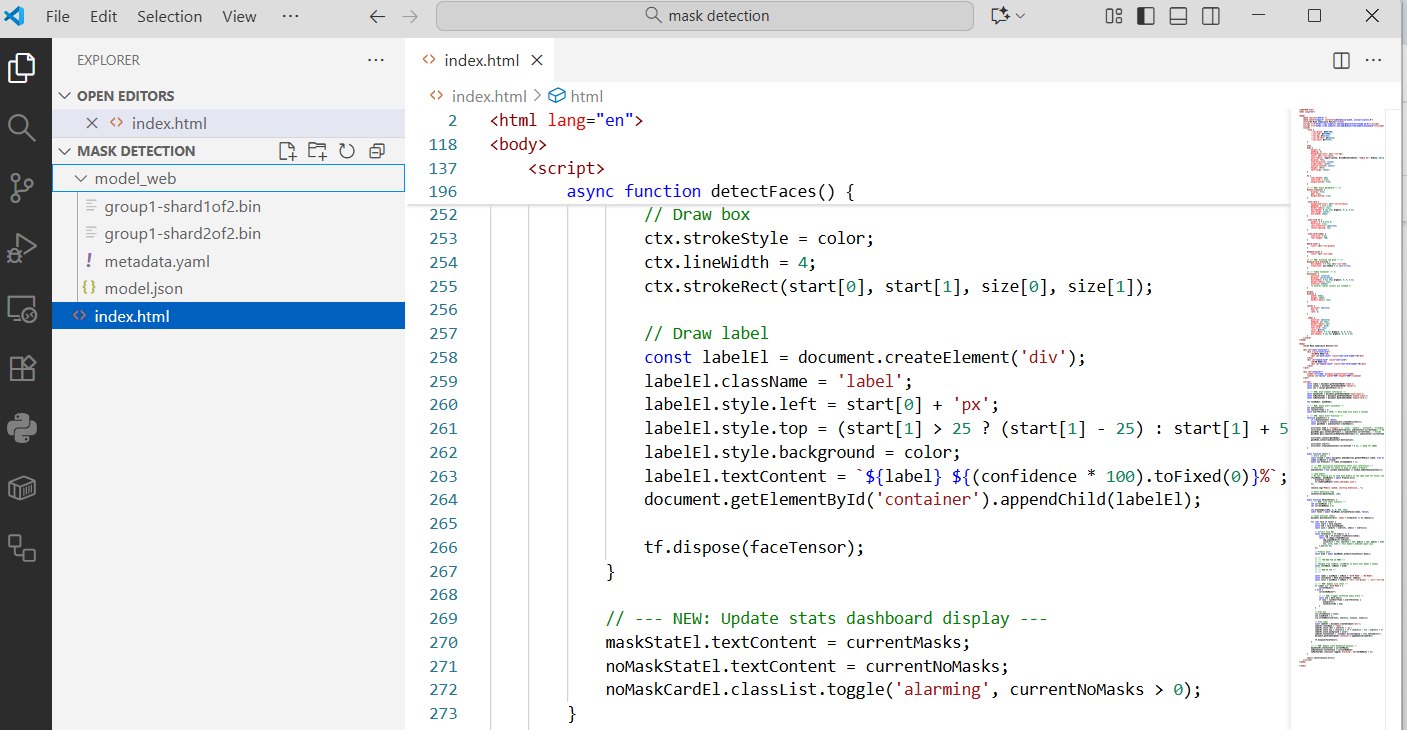

# Live Demo  (you can host on github pages too)

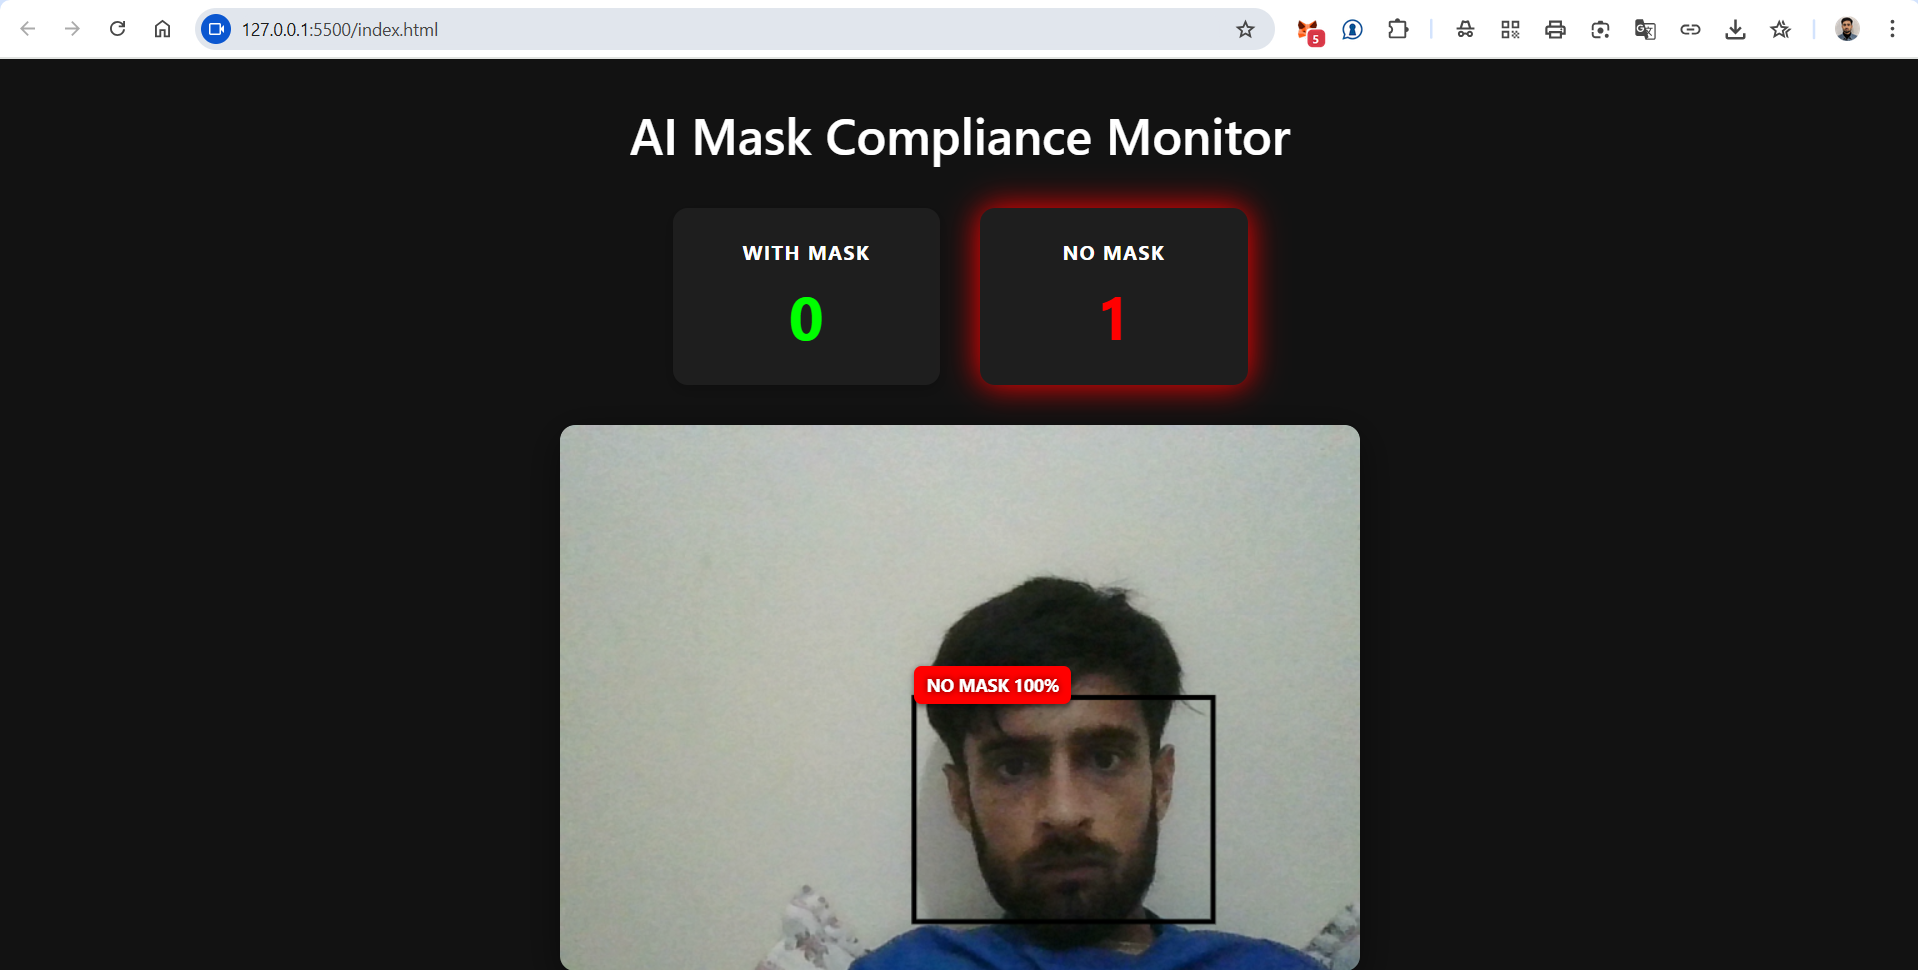